In [14]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.autograd import Variable
from io import open
from PIL import Image
import pathlib
import glob
import os

In [15]:
import matplotlib.pyplot as plt

In [16]:
x_train_loss = [0.43475809693336487, 0.3414214253425598, 0.2770894467830658, 0.23658722639083862, 0.2134728580713272, 0.18720652163028717, 0.1719711273908615, 0.16132009029388428, 0.14735372364521027, 0.14163340628147125]
x_train_accuracy = [0.8465454458339322, 0.8814982511618993, 0.9044846916774472, 0.9195534473671602, 0.9275070672224618, 0.9372095251784773, 0.943330458530976, 0.9474270518901825, 0.9520506923482344, 0.9545781227540606]
x_test_accuracy = [0.9028925619834711, 0.9411157024793388, 0.9597107438016529, 0.9483471074380165, 0.9183884297520661, 0.9576446280991735, 0.8708677685950413, 0.96900826446281, 0.9731404958677686, 0.9628099173553719]
y = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

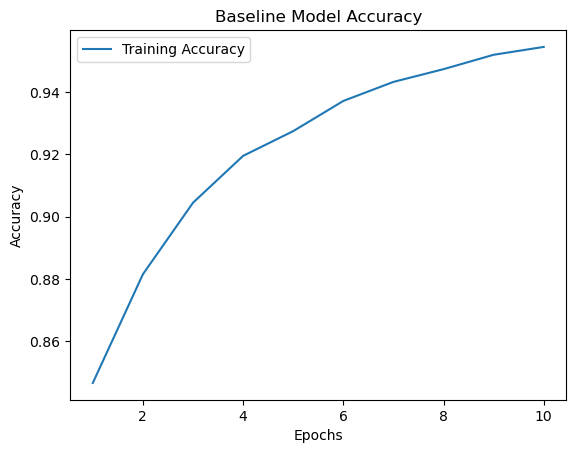

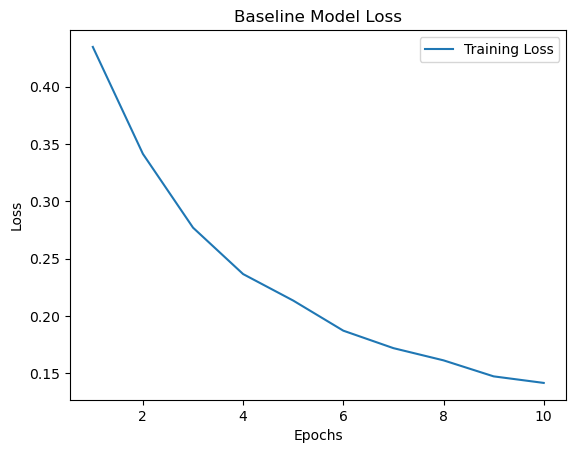

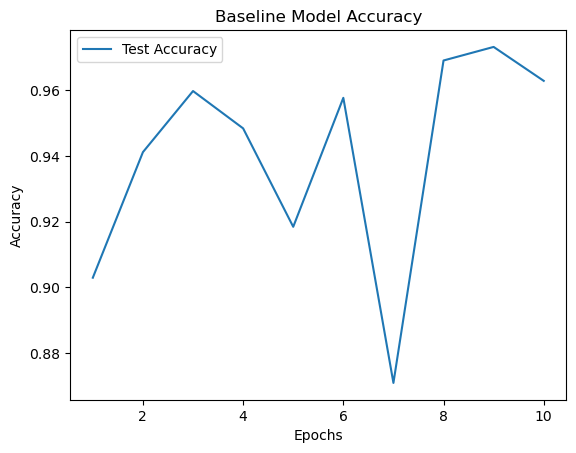

In [17]:
plt.subplot()
plt.title('Baseline Model Accuracy')
plt.plot(y, x_train_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy'])
plt.show()

plt.title('Baseline Model Loss')
plt.plot(y, x_train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss'])
plt.show()

plt.title('Baseline Model Accuracy')
plt.plot(y, x_test_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Test Accuracy'])
plt.show()

In [18]:
# Path for training and testing directory
train_path = 'content/OCT2017/train/'
pred_path = 'prediction'

img_width, img_height = 150, 150
batch_size = 32

In [19]:
# Categories
root = pathlib.Path(train_path)
classes = [file.name.split('/')[-1] for file in root.iterdir()]
classes

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [20]:
# CNN Network
class ConvNet(nn.Module):
    def __init__(self, num_classes = len(classes)):
        super(ConvNet,self).__init__()
        
        # Input shape= (256,3,150,150)
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        # Shape = (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        
        # Reduce the image size be factor 2
        # Shape = (256,12,75,75)
        self.pool=nn.MaxPool2d(kernel_size=2)
        
        # Shape = (256,20,75,75)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        
        # Shape = (256,32,75,75)
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        
        self.fc=nn.Linear(in_features=75 * 75 * 32, out_features = num_classes)
        
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
        #Above output will be in matrix form, with shape (256,32,75,75) 
        output=output.view(-1,32*75*75)
        output=self.fc(output)
            
        return output 

In [21]:
checkpoint=torch.load('best_checkpoint.model')
model=ConvNet(len(classes))
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=4, bias=True)
)

In [22]:
# Preprocessing
transformer = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(), #0-255 to 0-1, numpy to tensors
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 0-1 to [-1, 1], formula (x-mean)/std
])

In [23]:
# Prediction function
def prediction(img_path,transformer):
    image = Image.open(img_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input = Variable(image_tensor)

    output = model(input)
    
    index = output.data.numpy().argmax()
    
    pred = classes[index]
    
    return pred

In [24]:
# images_path = [os.path.basename(x) for x in glob.glob(pred_path + '/*.jpeg')]
images_path = glob.glob('prediction/*.jpeg')
images_path

['prediction\\CNV-53018-1.jpeg',
 'prediction\\CNV-53018-2.jpeg',
 'prediction\\CNV-81630-1.jpeg',
 'prediction\\CNV-81630-2.jpeg',
 'prediction\\DME-11053-1.jpeg',
 'prediction\\DME-15208-1.jpeg',
 'prediction\\DME-15208-2.jpeg',
 'prediction\\DME-30521-1.jpeg',
 'prediction\\DRUSEN-228939-1.jpeg',
 'prediction\\DRUSEN-228939-2.jpeg',
 'prediction\\DRUSEN-303435-1.jpeg',
 'prediction\\DRUSEN-95633-1.jpeg',
 'prediction\\NORMAL-12494-1.jpeg',
 'prediction\\NORMAL-12494-2.jpeg',
 'prediction\\NORMAL-12494-3.jpeg',
 'prediction\\NORMAL-9251-1.jpeg']

In [25]:
pred_dict = {}

for img in images_path:
    key = img[img.rfind('/') + 1:]
    pred_dict[key] = prediction(img, transformer)

In [26]:
pred_dict

{'prediction\\CNV-53018-1.jpeg': 'DME',
 'prediction\\CNV-53018-2.jpeg': 'CNV',
 'prediction\\CNV-81630-1.jpeg': 'CNV',
 'prediction\\CNV-81630-2.jpeg': 'CNV',
 'prediction\\DME-11053-1.jpeg': 'NORMAL',
 'prediction\\DME-15208-1.jpeg': 'DME',
 'prediction\\DME-15208-2.jpeg': 'DME',
 'prediction\\DME-30521-1.jpeg': 'DME',
 'prediction\\DRUSEN-228939-1.jpeg': 'DRUSEN',
 'prediction\\DRUSEN-228939-2.jpeg': 'DRUSEN',
 'prediction\\DRUSEN-303435-1.jpeg': 'DRUSEN',
 'prediction\\DRUSEN-95633-1.jpeg': 'DRUSEN',
 'prediction\\NORMAL-12494-1.jpeg': 'NORMAL',
 'prediction\\NORMAL-12494-2.jpeg': 'NORMAL',
 'prediction\\NORMAL-12494-3.jpeg': 'NORMAL',
 'prediction\\NORMAL-9251-1.jpeg': 'NORMAL'}

In [27]:
good_answer = 0
for key, predicted_element in pred_dict.items():
    tested_element = key.replace('prediction\\', '').split('-')[0]
    if tested_element == predicted_element:
        good_answer += 1
        
print(f"{(good_answer/len(pred_dict)) * 100}%")

87.5%
